In [3]:
import numpy as np 
import pandas as pd 
import os

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings("ignore")

## Read Data

In [6]:
path = "data/raw/asl_dataset"
img_df = pd.DataFrame()
file_names = os.listdir(path)
if ".DS_Store" in file_names:
    file_names.remove(".DS_Store")
img_paths = []
df = pd.DataFrame(columns=["img_names", "categories"])
for img_category in file_names:
    img_df = pd.DataFrame()
    img_df["img_names"] = os.listdir(os.path.join(path, img_category))
    img_df["categories"] = img_category
    df = pd.concat([df, img_df], axis=0, join="inner")
df["img_paths"] = path + "/" + df["categories"] + "/" + df["img_names"]
df

,img_names,categories,img_paths
0,hand1_0_bot_seg_1_cropped.jpeg,0,data/raw/asl_dataset/0/hand1_0_bot_seg_1_cropp...
1,hand1_0_bot_seg_2_cropped.jpeg,0,data/raw/asl_dataset/0/hand1_0_bot_seg_2_cropp...
2,hand1_0_bot_seg_3_cropped.jpeg,0,data/raw/asl_dataset/0/hand1_0_bot_seg_3_cropp...
3,hand1_0_bot_seg_4_cropped.jpeg,0,data/raw/asl_dataset/0/hand1_0_bot_seg_4_cropp...
4,hand1_0_bot_seg_5_cropped.jpeg,0,data/raw/asl_dataset/0/hand1_0_bot_seg_5_cropp...
...,...,...,...
65,hand5_z_dif_seg_1_cropped.jpeg,z,data/raw/asl_dataset/z/hand5_z_dif_seg_1_cropp...
66,hand5_z_dif_seg_2_cropped.jpeg,z,data/raw/asl_dataset/z/hand5_z_dif_seg_2_cropp...
67,hand5_z_dif_seg_3_cropped.jpeg,z,data/raw/asl_dataset/z/hand5_z_dif_seg_3_cropp...
68,hand5_z_dif_seg_4_cropped.jpeg,z,data/raw/asl_dataset/z/hand5_z_dif_seg_4_cropp...


## Data Visualization

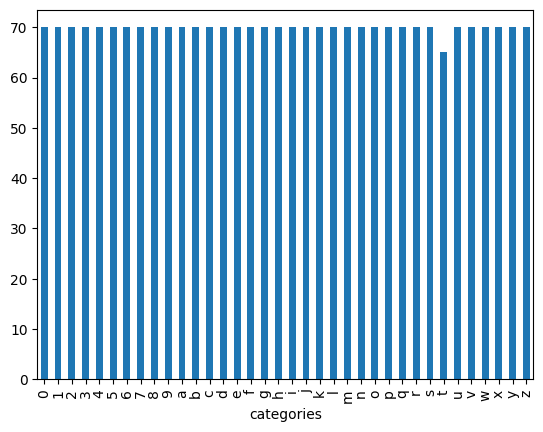

In [7]:
df["categories"].sort_values().value_counts(sort=False).plot(kind="bar");

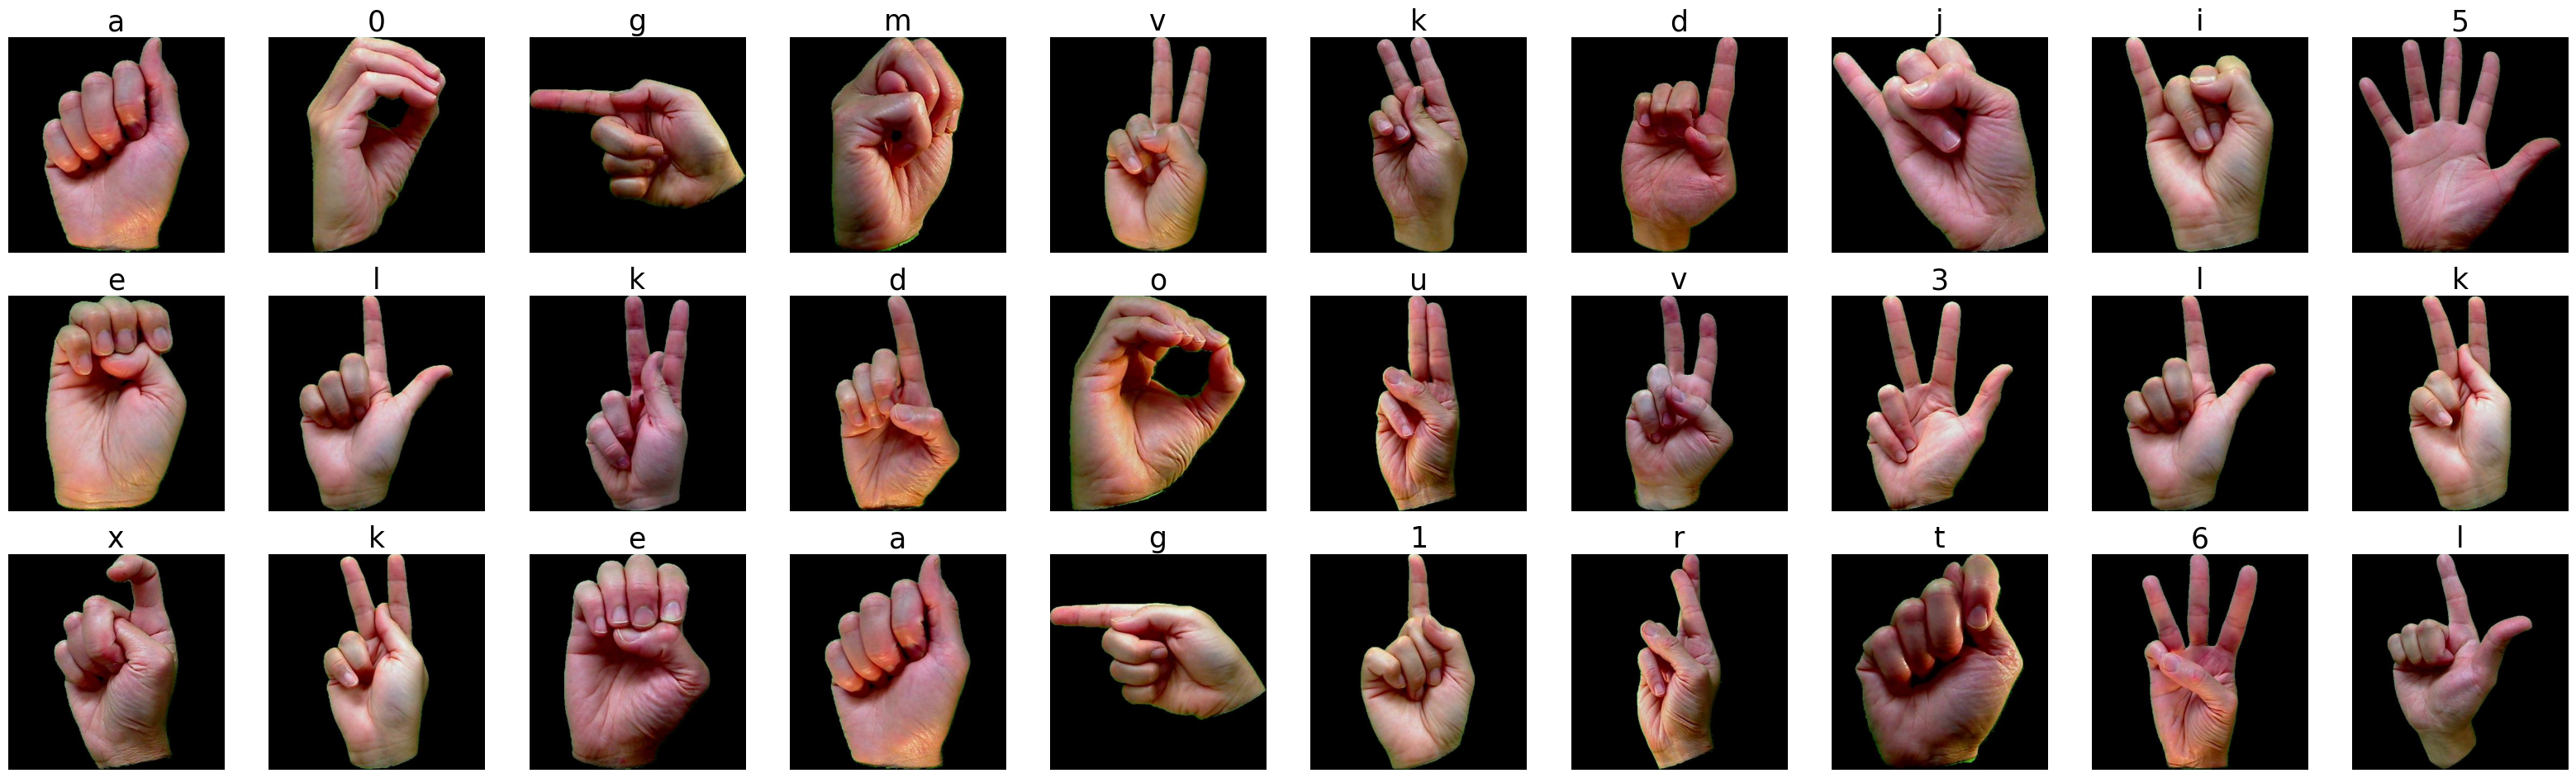

In [8]:
plt.figure(figsize=(40, 40))
for i in range (30):
    j = np.random.randint(df.shape[0])
    img = plt.imread(df["img_paths"].iloc[j])
    plt.subplot(10, 10, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df['categories'].iloc[j],fontsize=25)

## Data Preprocessing

In [9]:
X = df["img_paths"].values
Y = df["categories"]

In [10]:
lb = LabelEncoder()
Y_encode = lb.fit_transform(Y)
Y_encode = to_categorical(Y_encode)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encode, test_size=0.25, random_state=42)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=.5, random_state=42)
X_train.shape, X_test.shape

((1886,), (314,))

In [12]:
input_h, input_w = 224, 224

In [13]:
x_test_arr = np.zeros((X_test.shape[0], input_h, input_w,  3))

for i in range(len(X_test)):

    im = load_img(X_test[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_test_arr[i] = img_to_array(im)/255

x_train_arr = np.zeros((X_train.shape[0], input_h, input_w,  3))

for i in range(len(X_train)):

    im = load_img(X_train[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_train_arr[i] = img_to_array(im)/255

x_valid_arr = np.zeros((X_valid.shape[0], input_h, input_w,  3))

for i in range(len(X_valid)):

    im = load_img(X_valid[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_valid_arr[i] = img_to_array(im)/255

In [14]:
x_train_arr.shape, x_valid_arr.shape, x_test_arr.shape

((1886, 224, 224, 3), (315, 224, 224, 3), (314, 224, 224, 3))

In [15]:
Y_train.shape, Y_valid.shape, Y_test.shape

((1886, 36), (315, 36), (314, 36))

## Data Augmentation

In [16]:
train_datagen = ImageDataGenerator(rescale=1.,
                                      rotation_range=30,
                                      width_shift_range=0.05,
                                      height_shift_range=0.05,
                                      shear_range=0.05,
                                      zoom_range=0.1,
                                      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.)
test_datagen = ImageDataGenerator(rescale=1.)

In [17]:
test_gen = test_datagen.flow(x_test_arr, Y_test, batch_size=16, shuffle=False, seed=42)
train_gen = train_datagen.flow(x_train_arr, Y_train, batch_size=16, shuffle=True, seed=42)
valid_gen = valid_datagen.flow(x_valid_arr, Y_valid, batch_size=16, shuffle=False, seed=42)

## CNN Model

In [18]:
def cnn_model(input_h, input_w):
    model=Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(input_h, input_w, 3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),2,padding='same'))
    model.add(Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),2,padding='same'))
    model.add(Flatten())
    model.add(Dense(units=512,activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=36,activation='softmax'))
    model.summary()
    return model

In [19]:
model = cnn_model(input_h, input_w)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2025-03-09 17:16:13.240930: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │        18,468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,804 (4.43 MB)

 Trainable params: 1,160,804 (4.43 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [20]:
lr = ReduceLROnPlateau(monitor='val_accuracy', 
                       patience = 2, 
                       factor=0.5 , 
                       verbose = 1)

es = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

filepath="weights-improvement.keras"
checkpoint = ModelCheckpoint(filepath,
                             monitor= "val_accuracy" ,
                             verbose=1,
                             save_best_only=True,
                             mode= "max")

In [21]:
callbacks_list = [checkpoint]

In [ ]:
epochs = 50
batch_size = 32
history = model.fit(train_gen,
                    steps_per_epoch=x_train_arr.shape[0] // batch_size,
                    validation_data=valid_gen,
                    validation_steps = x_valid_arr.shape[0] // batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list)

hist_=pd.DataFrame(history.history)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()